#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо простроить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [141]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit


from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
from math import sqrt, ceil
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)



In [142]:
dt = pd.read_csv('/datasets/taxi.csv')

In [143]:
dt.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [144]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [145]:
dt.isna().sum()

datetime      0
num_orders    0
dtype: int64

Отсутствуют пропуски.

In [146]:
dt.duplicated().sum()

0

Отсутствуют дубликаты.

Ресемплируем данные по одному часу 

In [147]:
dt['datetime'] = pd.to_datetime(dt['datetime'])
dt.set_index('datetime', inplace = True)

В каждом часе будет сумма заказов за этот верменной промежуток:

In [149]:
dt = dt.resample('1H').sum().astype(int)

## Анализ

Посмотрим минимум и максимум заказов:

In [150]:
print('Минимальное количество заказов :', {dt['num_orders'].min()})
print('Максимальное количество заказов :', {dt['num_orders'].max()})

Минимальное количество заказов : {0}
Максимальное количество заказов : {462}


Скользящее среднее

In [151]:
dat = dt['2018-03-01':'2018-03-10'].copy()

In [152]:
dat['rolling_mean'] = dat['2018-03-01':'2018-03-10'].rolling(10).mean()

<AxesSubplot:xlabel='datetime'>

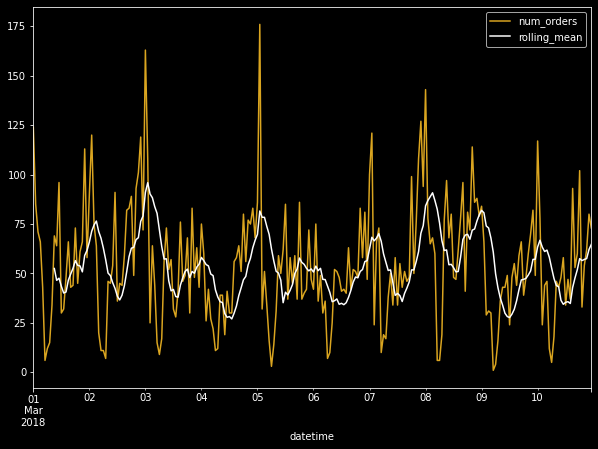

In [153]:
dat.plot(figsize = [10,7], color = ['goldenrod','white'])

* **Каждый день наблюдаются подобные предыдущим дням качели количества заказов.**

**Тренды**

In [154]:
decomposed = seasonal_decompose(dt, period = 16)

<AxesSubplot:xlabel='datetime'>

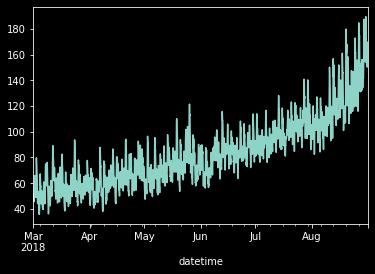

In [155]:
decomposed.trend.plot(ax = plt.gca())

* **Тренды на прогрессивный рост количества заказов такси, эквивалентно месяцам.**


- чтобы полностью утверждать тренды на рост заказов необходимы данные за большей временной период, т.к. этот рост может быть обусловленн сезонностью.

**Сезонность**

Text(0.5, 1.0, 'Масштаб: весь набор данных')

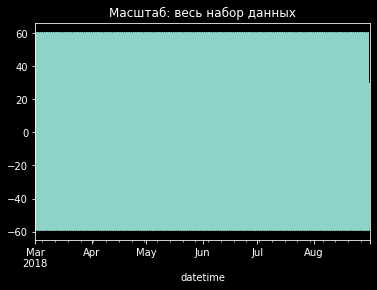

In [156]:
seasonal_decompose(dt).seasonal.plot()
plt.title('Масштаб: весь набор данных')

В обозримом масштабе не выявляется периодических колебаний значений.

Изменим масштаб:

Text(0.5, 1.0, 'Масштаб: месяц')

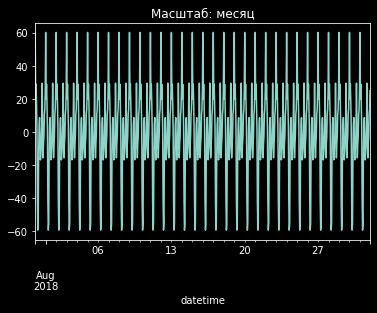

In [157]:
seasonal_decompose(dt).seasonal['2018-07-31':'2018-08-31'].plot(ax = plt.gca())
plt.title('Масштаб: месяц')

Text(0.5, 1.0, 'Масштаб: 3 дня')

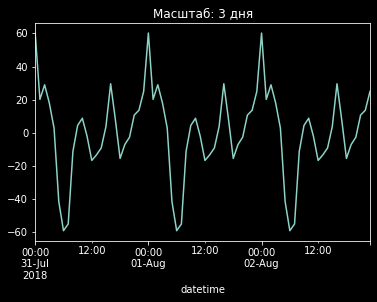

In [158]:
seasonal_decompose(dt).seasonal['2018-07-31':'2018-08-02'].plot(ax = plt.gca())
plt.title('Масштаб: 3 дня')

Повторяющиеся, периодические колебания проявляют себя в масштабе дня.

Создание признаков 

In [159]:
# Функция добавляет новые признаки


def make_features(dt, max_lag, rolling_mean_size):
    data = dt.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    
    for lag in range(1,max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data
    
        

In [160]:
data = make_features(dt, 14, 6)

In [161]:
data.dropna(inplace = True)

* **Посмотрим среднее изменение количества заказов в течении дня в разыне месяцы**

	 	 Темнее - больше номер месяца


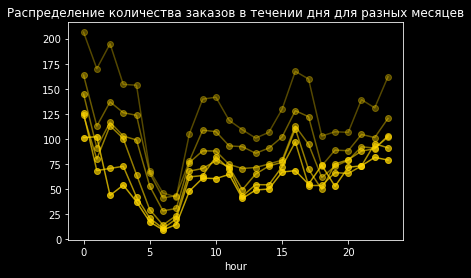

In [162]:
for i in range(3,9,1):
    data.loc[f'2018-0{i}'].groupby('hour')['num_orders'].agg('mean').plot(
    ax = plt.gca(), color = 'gold', alpha = 1 - (i/12),style = 'o-')
    
plt.title('Распределение количества заказов в течении дня для разных месяцев')
print('\t \t Темнее - больше номер месяца')

* **Полученный график позволяет нам утверждать:**
        1. В 5-6 утра наблюдается локальный минимум по околичеству поступающих заказов.
        2. в 9-11 часов первый, локальный, пик заказов.
        3. в 15-17 второй, локальный, пик заказов.
        4. в 22-01 гловбальный пик количества заказов такси.

Text(0.5, 1.0, 'Зависимость среднего и медианы от месяца')

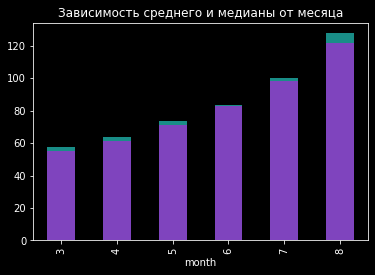

In [163]:
metrics = ['mean','median']
clr = ['lightseagreen','darkorchid']
for i in range(len(metrics)):
    data.groupby('month')['num_orders'].agg(metrics[i]).plot(kind = 'bar',ax = plt.gca(),color = clr[i],alpha = 0.8)

    
plt.title('Зависимость среднего и медианы от месяца')

* **Соответственно терндам - рост заказов взаимосвязан с месяцем**

## Обучение

Разделим выборки соответственно условию задачи.

* Для сравнения моделей и подборова гиперпараметров используем валидационную выборку.

In [164]:
#  создание валидационной выборки 
train, split = train_test_split(data, test_size = 0.2, shuffle = False)

test, valid = train_test_split(split, test_size = 0.5, shuffle = False)

In [165]:
y_train = train['num_orders']
x_train = train.drop(columns = ['num_orders'])
y_valid = valid['num_orders']
x_valid = valid.drop(columns = ['num_orders'])
y_test = test['num_orders']   
x_test  = test.drop(columns = ['num_orders']) 

* Добавим крос валидацию для временных рядов

In [166]:
time_series_cv = TimeSeriesSplit(n_splits = 2)

### Linear Regression

In [167]:
model = LinearRegression()
model.fit(x_train,y_train)
lire_pred = model.predict(x_valid)
rmse_lire = mean_squared_error(y_valid,lire_pred, squared = False )

print(f'RMSE: {rmse_lire}')

RMSE: 54.58694527191915


* Модель не добралась до порого RMSE < 48


### DecisionTreeRegressor


In [168]:
param_tree = {'max_depth': 5,
        'min_samples_split': 2,
             'min_samples_leaf': 2}

In [169]:
grid_param = {'max_depth': [4,8,12,16],
        'min_samples_split': [2,4,6],
             'min_samples_leaf':[2,4,6]}

In [170]:
tree = DecisionTreeRegressor(max_depth = param_tree['max_depth'],
                             min_samples_split = param_tree['min_samples_split'],
                            min_samples_leaf = param_tree['min_samples_leaf'])

In [171]:
grid = GridSearchCV(tree, grid_param, verbose = 1, cv = time_series_cv, n_jobs = -1)
grid.fit(x_train,y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=DecisionTreeRegressor(max_depth=5, min_samples_leaf=2),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 4, 6]},
             verbose=1)

In [172]:
param_tree['max_depth'] = grid.best_params_['max_depth']
param_tree['min_samples_split'] = grid.best_params_['min_samples_split']
param_tree['min_samples_leaf'] = grid.best_params_['min_samples_leaf'] 

In [173]:
tree = DecisionTreeRegressor(max_depth = param_tree['max_depth'],
                             min_samples_split = param_tree['min_samples_split'],
                            min_samples_leaf = param_tree['min_samples_leaf'])
tree.fit(x_train,y_train)
tree_pred = tree.predict(x_valid)
rmse_tree = mean_squared_error(y_valid, tree_pred, squared = False)

print(f'RMSE: {rmse_tree}')

RMSE: 52.84107088076739


* Модель не добралась до порога RMSE < 48

### Random Forest Regressor

In [174]:
param_forest = {'max_depth': 5,
        'n_estimators': 100,
               'min_samples_leaf':2,
             'min_samples_split':2}

In [175]:
grid_param = {'max_depth': [4,8,12,16],
        'n_estimators': [50,100,150,200],
             'min_samples_leaf':[2,5],
             'min_samples_split':[2,5]}

In [176]:
forest = RandomForestRegressor(max_depth = param_forest['max_depth'],
                              n_estimators = param_forest['n_estimators'],
                              min_samples_leaf =  param_forest['min_samples_leaf'],
                              min_samples_split =  param_forest['min_samples_split'])

In [177]:
grid = GridSearchCV(forest,grid_param, verbose = 1, cv = time_series_cv, n_jobs = -1)
grid.fit(x_train,y_train)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=RandomForestRegressor(max_depth=5, min_samples_leaf=2),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [178]:
param_forest['max_depth'] = grid.best_params_['max_depth']
param_forest['n_estimators'] = grid.best_params_['n_estimators']
param_forest['min_samples_leaf'] = grid.best_params_['min_samples_leaf']
param_forest['min_samples_split'] = grid.best_params_['min_samples_split']

In [179]:
forest = RandomForestRegressor(max_depth = param_forest['max_depth'],
                              n_estimators = param_forest['n_estimators'],          
                               min_samples_leaf =  param_forest['min_samples_leaf'],
                              min_samples_split =  param_forest['min_samples_split'])
forest.fit(x_train,y_train)
forest_pred = forest.predict(x_valid)
rmse_forest = mean_squared_error(y_valid, forest_pred, squared = False)

print(f'RMSE: {rmse_forest}')

RMSE: 51.15771973052188


* Модель не добралась до порога RMSE < 48

### NN

In [180]:
x_train_nn = torch.FloatTensor(x_train.values)
x_test_nn = torch.FloatTensor(x_test.values)
x_valid_nn = torch.FloatTensor(x_valid.values)
y_train_nn = torch.FloatTensor(y_train.values)
y_test_nn = torch.FloatTensor(y_test.values)
y_valid_nn = torch.FloatTensor(y_valid.values)

Ограничимся двумя скрытыми слоями в полносвязной сети.

In [181]:
class Net(nn.Module):
    def __init__(self,n_in_neurons,n_hidden_neurons_1,
                 n_hidden_neurons_2,n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons,n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode = 'fan_out',nonlinearity = 'relu')
        nn.init.uniform_(self.fc1.bias, a = 0.5,b = 0.7)
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc2.bias, a = 0.5, b = 0.7)
        
        nn.init.uniform_(self.fc3.weight, a = 0.5, b =0.7)
        nn.init.uniform_(self.fc3.bias, a = 0.5, b = 0.7)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        
        return x

Используем перебор по количеству нейронов  


и скорости обучения.

In [182]:
n_in_neurons = 19
n_hidden_neurons_1 = [18,36,72] 
n_hidden_neurons_2 = [18,36]
n_out_neurons = 1
learning_rate = [0.01, 0.02, 0.03]




top_rmse_nn = 15000
top_epoch_1 = None
top_preds_1 = None
top_count_hidden_neurons_1 = None
top_count_hidden_neurons_2 = None
num_epochs = 2000
top_learning_rate = None


for h in range(len(n_hidden_neurons_1)):
    for k in range(len(n_hidden_neurons_2)):
        for lrt in learning_rate:
            net = Net(19,n_hidden_neurons_1[h], n_hidden_neurons_2[k],1)
            optimizer = torch.optim.Adam(net.parameters(), lr = lrt)
            loss = nn.MSELoss()
            for epoch in range(num_epochs):

                optimizer.zero_grad()

                preds = net.forward(x_train_nn).flatten()

                loss_value = loss(preds, y_train_nn)

                loss_value.backward()

                optimizer.step()

                if epoch % 5 == 0 or epoch == num_epochs -1:
                    net.eval()
                    test_preds = net.forward(x_valid_nn)
                    train_preds = net.forward(x_train_nn)
                    rmse = sqrt(mean_squared_error(y_valid_nn.detach().numpy(), test_preds.detach().numpy()))
                    rmse_train = sqrt(mean_squared_error(y_train_nn.detach().numpy(), train_preds.detach().numpy()))
                    if rmse < top_rmse_nn:
                        top_rmse_nn = rmse
                        top_epoch_1 = epoch
                        top_preds_1 = test_preds
                        top_learning_rate = lrt
                        top_count_hidden_neurons_1 = n_hidden_neurons_1[h]
                        top_count_hidden_neurons_2 = n_hidden_neurons_2[k]
                #if epoch % 100 == 0 or epoch == num_epochs -1:
                 #   print(f'Step {epoch}:',rmse)
              

            
print(f'top rmse: {top_rmse_nn}','\n'
                  , f'top epoch: {top_epoch_1}',
         f'top hidden_neurons_1: {top_count_hidden_neurons_1}',
         f'top hidden_neurons_2: {top_count_hidden_neurons_2}',
      f'top learning_rate : {top_learning_rate}'
     )

top rmse: 44.603383189979965 
 top epoch: 1995 top hidden_neurons_1: 18 top hidden_neurons_2: 18 top learning_rate : 0.03


* Модель прошла порог в RMSE < 48

Сравнение показателей моделей:

In [183]:
pd.DataFrame({'Logistic Regression': rmse_lire,'DecisionTreeRegressor': rmse_tree, 'RandomForestRegressor':rmse_forest,
          'Neural Network': top_rmse_nn}, index = ['RMSE'])

,Logistic Regression,DecisionTreeRegressor,RandomForestRegressor,Neural Network
RMSE,54.586945,52.841071,51.15772,44.603383


В сравнении 4'ех моделей луче всех себя показала полносвязная нейронная сеть.


На подобранных в этом абзаце гиперпараметрах будем проводить дальнейшее тестировании модели нейронной сети.

## Тестирование

Сначала сравним подобранную модель с дефольными моделями предсказывающими значение ряда медианой и среднем:

### Дефолтная модель

In [184]:
predict_mean = np.ones(test.shape[0]) * train['num_orders'].mean()
predict_median = np.ones(test.shape[0]) * train['num_orders'].median()
rmse_mean = mean_squared_error(y_test, predict_mean, squared = False)
rmse_median = mean_squared_error(y_test, predict_median, squared = False)

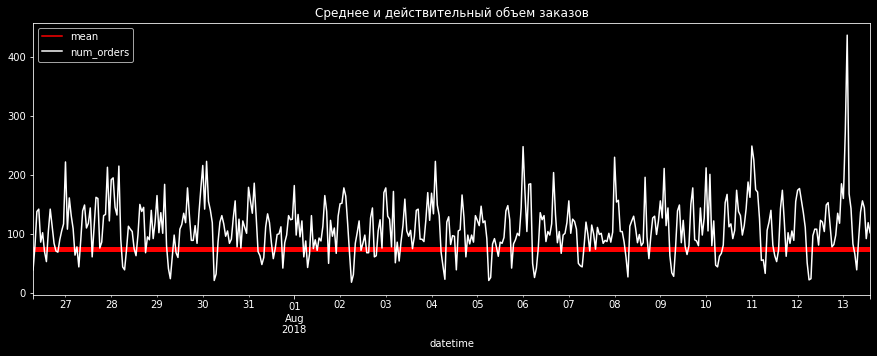


					RMSE mean: 58.208277009676856



In [185]:
fig, ax = plt.subplots()
graph = pd.DataFrame(predict_mean, 
                     index = y_test.index,
                     columns = ['mean']).join(pd.DataFrame(predict_median,
                                                           index = y_test.index,
                                                           columns = ['median'])).join(y_test)

graph.loc[:,['mean','num_orders']].plot(ax = ax, color = ['red','white'], figsize = [15,5])

for line in ax.get_lines():
    if line.get_label() == 'mean':
        line.set_linewidth(5)
plt.title('Среднее и действительный объем заказов')        
plt.show()
print(f'\n\t\t\t\t\tRMSE mean: {mean_squared_error(y_test, predict_mean, squared = False)}\n')

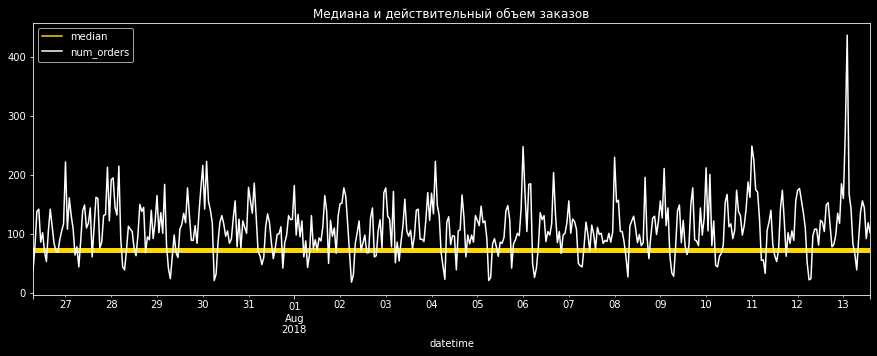


					RMSE median: 59.71561391675167



In [186]:
fig, ax = plt.subplots()
graph.loc[:,['median','num_orders']].plot(color = ['gold','white'], ax = ax, figsize = [15,5])
for line in ax.get_lines():
    if line.get_label() == 'median':
        line.set_linewidth(5)
plt.title('Медиана и действительный объем заказов')
plt.show()
print(f'\n\t\t\t\t\tRMSE median: {mean_squared_error(y_test, predict_median, squared = False)}\n')

Статичные модели справились хуже исследуемых в предыдущем абзаце.

### Статичная модель отвечающаяя предыдущим значением ряда(часа)

In [187]:
pred_previosu = test.shift(fill_value = train['num_orders'].iloc[-1])
pred_previosu = pred_previosu['num_orders']
rmse_previosu  = mean_squared_error(y_test,pred_previosu, squared = False)

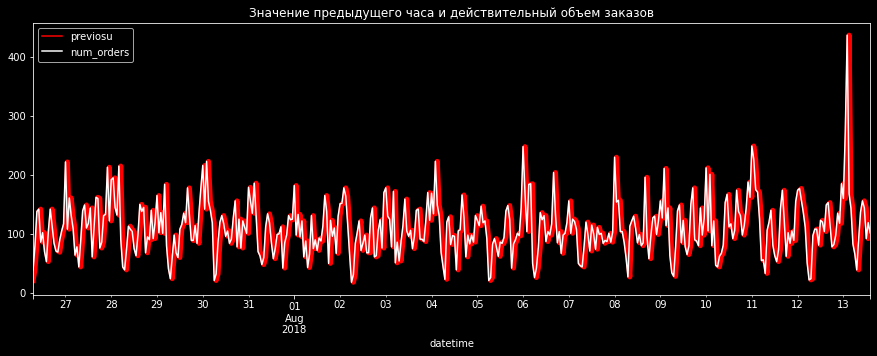


					RMSE previorus: 47.210385028566066



In [188]:
fig, ax = plt.subplots()
graph = pd.DataFrame(np.array(pred_previosu), 
                     index = y_test.index,
                     columns = ['previosu']).join(y_test)

graph.loc[:,['previosu','num_orders']].plot(ax = ax, color = ['red','white'], figsize = [15,5])

for line in ax.get_lines():
    if line.get_label() == 'previosu':
        line.set_linewidth(5)
plt.title('Значение предыдущего часа и действительный объем заказов')        
plt.show()
print(f'\n\t\t\t\t\tRMSE previorus: {mean_squared_error(y_test, pred_previosu, squared = False)}\n')

Предсказания статичной модели "предыдущего значения ряда" прошли проверку на точность RMSE < 48 и показала себя лучше 3\4 моделей рассмотренных в предыдущем абзаце.

### Избранная модель

In [189]:


net = Net(19,top_count_hidden_neurons_1, top_count_hidden_neurons_2,1)
optimizer = torch.optim.Adam(net.parameters(), lr = top_learning_rate)
loss = nn.MSELoss()
num_epoch = top_epoch_1

for epoch in range(num_epoch):
    optimizer.zero_grad()
    preds = net.forward(x_train_nn).flatten()
    loss_value = loss(preds, y_train_nn)
    loss_value.backward()
    optimizer.step()
    


In [190]:
test_pred_nn = net.forward(x_test_nn)
rmse_nn = sqrt(mean_squared_error(y_test_nn.detach().numpy(), test_pred_nn.detach().numpy()))
print(f'RMSE Neural Network на тестовой выборке : {rmse_nn}')

RMSE Neural Network на тестовой выборке : 35.61775899546987


### График предсказаний избранной модели

<AxesSubplot:xlabel='datetime'>

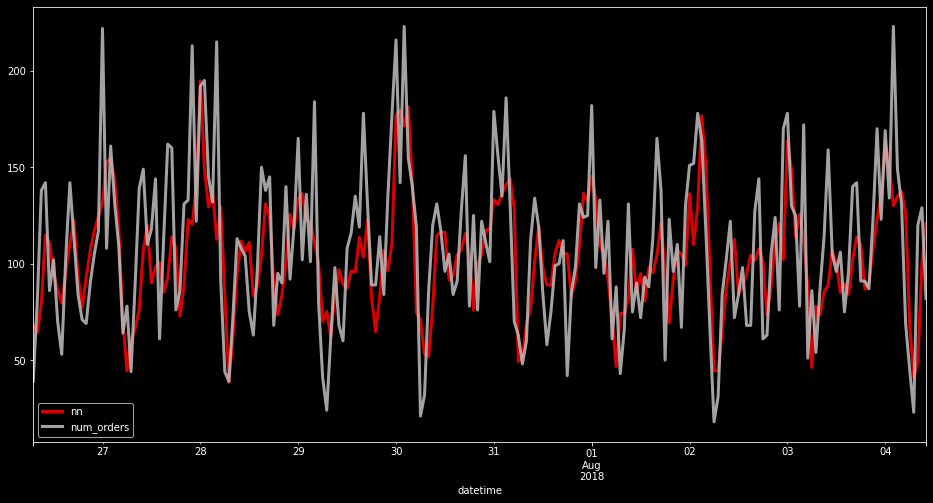

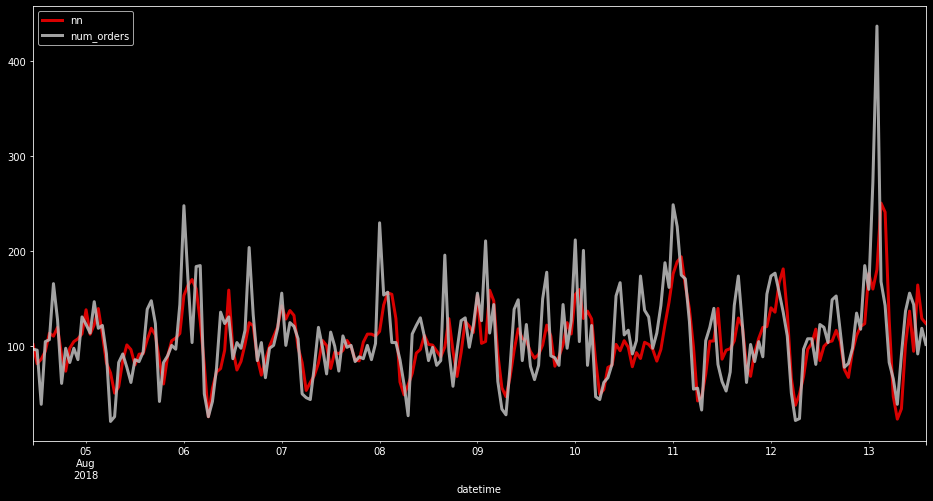

In [191]:
test_graph_nn = pd.DataFrame(test_pred_nn.detach().numpy(), index = y_test.index, columns = ['nn']).join(y_test)
test_graph_nn.iloc[:(int(test_graph_nn.shape[0]/2))].plot(color = ['red','silver'], figsize = [16,8], lw = 3, alpha = 0.85)
test_graph_nn.iloc[(int(test_graph_nn.shape[0]/2)):].plot(color = ['red','silver'], figsize = [16,8], lw = 3, alpha = 0.85)

<AxesSubplot:>

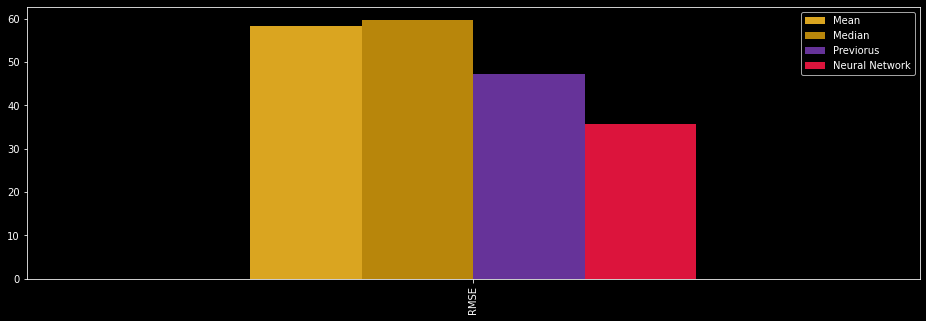

In [192]:
end_stats = pd.DataFrame({'Mean':rmse_mean,'Median':rmse_median,'Previorus':rmse_previosu,'Neural Network':rmse_nn}, index = ['RMSE'])
end_stats.plot(kind = 'bar', color =['goldenrod','darkgoldenrod','rebeccapurple','crimson'], figsize = [16,5])


Вывод:
1. Модель нейронной сети прошла порог точности предсказания RMSE < 48.
2. Модель нейронной сети прошла проверку на адекватность и показала себя лучеш статичных моделей.
3. Статичная модель предсказания количества заказов значением предыдущего часа тоже прошла порог RMSE < 48.

* Для использования модели в ревльных условиях объективно использование обученнной нейронной сети.

## Вывод

### Проделанная работа

Для прогнозирования заказов такиси было выполнено:
* Проведен осмотр данных на чистоту(дубликаты + пропуски)
* Ресемплирование по одному часу (согласно условию задачи)
* Тренд:
        1. Рост количества заказов параллельно возрастанию номера месяца.
        
        
* Выявленна закономерность количества заказов в течении дня, сохраняющаяся для всех месяцeв:
        1. В 5-6 утра наблюдается локальный минимум по околичеству поступающих заказов.
        2. в 9-11 часов первый, локальный, пик заказов.
        3. в 15-17 часов второй, локальный, пик заказов.
        4. в 22-01 часов глобальный пик количества заказов такси.
        
* На валидационной выборке проведено исследование моделей машинного обучение и нейронной сети:
        1. LogisticRegression 
        2. DecisionTreeRegressor 
        3. RandomForestRegressor
        4. Feedforward neural network
        
* Выбрана лучшая модель прошедная порог RMSE < 48
* Проведено тестирование модели на адекватность и на тестовой выборке.

### Проблематика исследуемых данных для прогнозирования временных рядов

* Имеющийся набор данных подчиняется тренду увеличения количества заказов такси соответствеенно месяцу, с марта до августа, так что:
        1. Не позволяет моделям определить сезонность в данных.
        2. Не позволяет утверждать продолжение закономерности "рост месяца -рост заказов", для осенни-зимнего периода.
 

### Прогнозирование заказов такси

* Исследуемы модели показали следующую эффективность:
        1. LogisticRegression - не прошла порог RMSE < 48
        2. DecisionTreeRegressor - не прошла порог RMSE < 48 со всеми исследуемыми гиперпараметрами
        3. RandomForestRegressor - не прошла порог RMSE < 48 со всеми исследуемыми гиперпараметрами
        4. Feedforward neural network - прошла порог RMSE < 48
        
* Итоговое тестирование показало:
        1. Полное превосходство модели Neural Network над статичными моделями, пройдя порог адекватности
        2. Эффективности Neural Netwrok на тестовой выборке
        3. Эффективности статичной модели, прогнозирующей запросы количества такси предыдущем значением ряда(спросом предыдущего часа) в рамках RMSE < 48

**Итог:**


**Использование нейронной сети для прогнозирования заказов такси является наиболее эффективным методом.**

**Качество прогноза было выполненно на данных со статичным трендом роста объема заказов соответственно номеру месяца, что не позволяет утверждать такую же эффективность для других сезонов, в случае нарушения этой закономерности.**

**Для эффективности прогнозирования необходимо продолжение сбора данных, особенно за отсутствующие сезонны, с последующем обучение сети на новых данных**

Избранная нейронная сеть показала эффективность со следующими гиперпараметрами:

* Функция активации 1 скрытого слоя: ReLU
* Функция активации 2 скрытого слоя: ReLU

* Ицициализация весов - Kaiming 

* Количество нейронов первого скрытого слоя - 18
* Количество нейронов второго скрытого слоя - 18

* Оптимизатор градиентного спуска - Adam

* Количество эпох - 1995

    Сеть показала точность:
        1. Валидационная RMSE = 44.6
        2. Тестовая RMSE = 35.6